# Run Camera Calibration to Remove Effect of MTF

The Camera System including lens, sensor, and early pipeline processing does not necessarily have an equal effect on all spatial frequencies - some could be more dampened more than others and some could be boosted. Given that the Spatiotemporal Power Spectrum measure The Modulation Transfer Function describes this effect

## Dependencies

In [1]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import math
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 5.0)
import utils.bins_to_pngs as bin2png
import stftoolkit as stf
import cv2
import scipy.optimize
import scipy.signal

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/hmet_data/feb2021/'
trial_num = '002'
data_dir = os.path.join(base_dir, 'raw', '2021_02_19', trial_num)
#output_dir = os.path.join(base_dir, 'analysis', 'mtf', trial_num)
#output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 400

reconvert=False

## Specify Directories for Exmaple

In [3]:
example_trial = 'calib_mtf/calib'
iteration = trial_num
#trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, iteration)
save_dir = os.path.join('./output', example_trial, iteration)

try:
    os.makedirs(save_dir)
    os.makedirs(pngs_dir)
except:
    print(f'{save_dir} already made!')

#analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
#common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


./output/calib_mtf/calib/002 already made!


## Convert Frames to PNGS

In [4]:
binfilename = os.path.join(data_dir,'ximea','ximea',f'frames_0_{save_batchsize-1}.bin')
first_fnum = 0
if(reconvert):
    bin2png.convert_bin_pngs(binfilename, first_fnum, save_batchsize, pngs_dir)
else:
    print('Skipping conversion step!')

Skipping conversion step!


## Read in Imaged Edge

In [5]:
pngs_dir

'/hmet_data/feb2021/pngs/calib_mtf/calib/002'

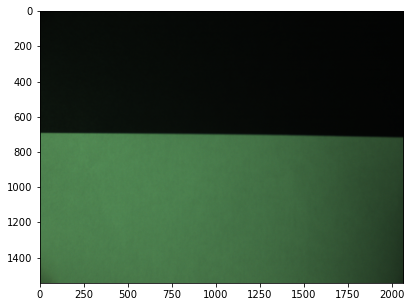

In [6]:
i=30
frame = cv2.imread(os.path.join(pngs_dir, f'frame_{i}.png'))
plt.imshow(frame)

## Remove Image Warping
Read in Camera Matrix and Distortion Matrix as measured with checkerboard pattern to remove camera distortion

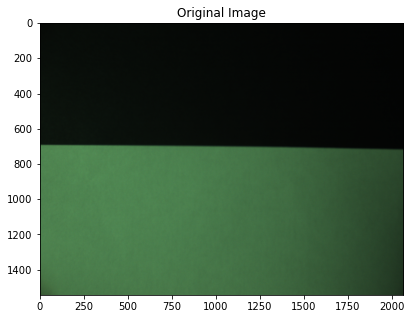

Text(0.5, 1.0, 'Undistorted Image')

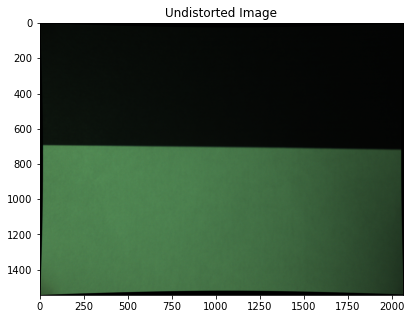

In [7]:
calibration_fname = os.path.join('/','hmet_data','calibration', 'analysis',"calibration_ximea_distortion.yaml")

with open(calibration_fname) as f:
    loadeddict = yaml.load(f, Loader=yaml.BaseLoader)
mtx = np.asarray(loadeddict.get('camera_matrix'), dtype='float32')
dist = np.asarray(loadeddict.get('dist_coeff'), dtype='float32')

h, w = frame.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

frame_undistorted = cv2.undistort(frame, mtx, dist, None, newcameramtx)
plt.imshow(frame)
plt.title('Original Image')
plt.show()
plt.imshow(frame_undistorted)
plt.title('Undistorted Image')

## Crop to Remove Edges

Text(0.5, 1.0, 'Undistorted Image')

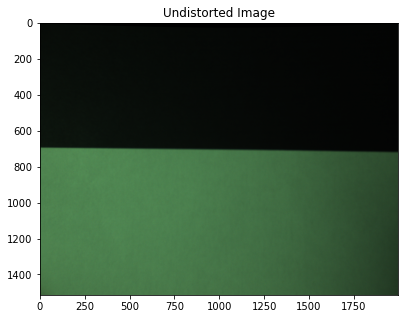

In [8]:
frame_undistorted = frame_undistorted[0:-30,30:-40,:]
plt.imshow(frame_undistorted)
plt.title('Undistorted Image')

## Simple White Balance
I'm not sure if this is strictly necessary for the alignment and subsequent processing but I really don't want to look at this green/yellow image

Lowval:  3
Highval:  81
Lowval:  4
Highval:  136
Lowval:  3
Highval:  83


Text(0.5, 1.0, 'White Balanced Frame')

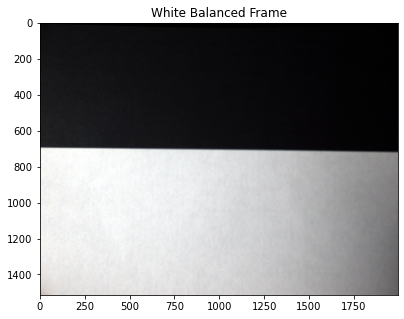

In [9]:
#from https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        print("Lowval: ", low_val)
        print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

wb_frame_undistorted = simplest_cb(frame_undistorted, 3)
plt.imshow(wb_frame_undistorted)
plt.title('White Balanced Frame')

Ok this is much less annoying to look at! Unclear though if this is really the correct algorithm.

## Take mean to make Image Greyscale
Do this for both the white balanced and the original images

Text(0.5, 1.0, 'White Balanced Frame - Greyscale')

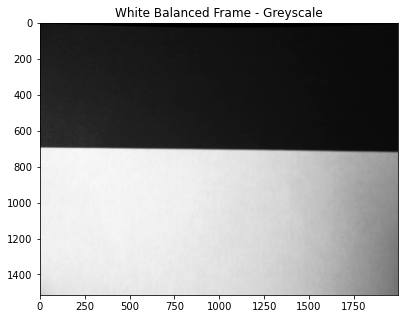

In [10]:
plt.imshow(np.mean(frame_undistorted,axis=-1),cmap='Greys_r')
plt.title('White Balanced Frame - Greyscale')

Text(0.5, 1.0, 'Frame - Greyscale')

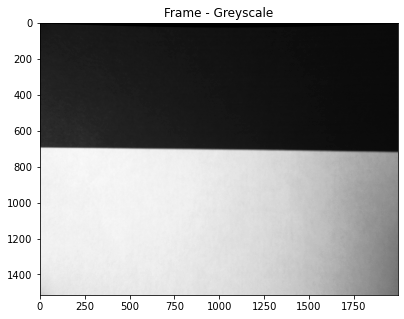

In [11]:
frame_grey = np.mean(frame_undistorted,axis=-1)
plt.imshow(frame_grey,cmap='Greys_r')
plt.title('Frame - Greyscale')

## Crop Dark Edge

Text(0.5, 1.0, 'Frame - Greyscale')

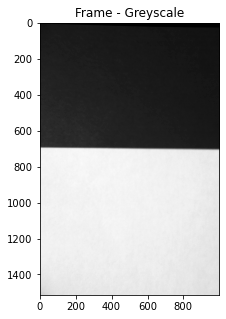

In [12]:
frame_grey = frame_grey[:,:1000]
plt.imshow(frame_grey,cmap='Greys_r')
plt.title('Frame - Greyscale')

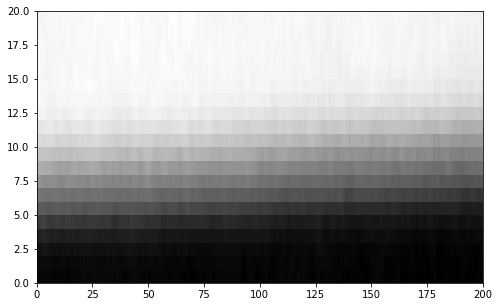

In [37]:
crop = frame_grey[650:750,:]
crop = crop[40:60,:]
crop = crop[:,400:600]

plt.pcolormesh(crop,cmap='Greys_r')


## Detect Edge with Laplacian Filter

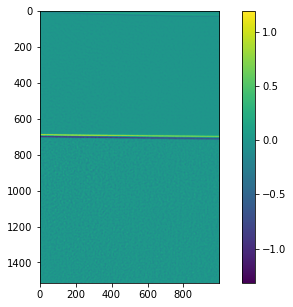

In [13]:
kern_width = 10
kernel = np.ones((kern_width,kern_width),np.float32)/(kern_width**2)
filtered_frame = cv2.filter2D(frame_grey,-1,kernel) #first smooth
filtered_frame = cv2.Laplacian(filtered_frame, cv2.CV_64F) #then Laplacian Filter
plt.imshow(filtered_frame)
plt.colorbar()

Peaks at: 692 704
Width is: 50


Text(0.5, 1.0, 'Cropped Slant Edge Area')

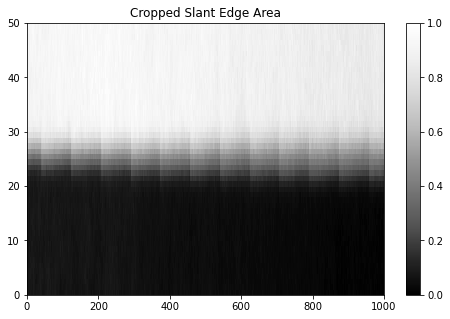

In [14]:
#these x/y axes are set for a vertical axis step function
peak_l = np.argmax(filtered_frame[:,0])
trough_l = np.argmin(filtered_frame[:,0])
center_l = round(np.mean((peak_l,trough_l)))

peak_r = np.argmax(filtered_frame[:,-1])
trough_r = np.argmin(filtered_frame[:,-1])
center_r = round(np.mean((peak_r,trough_r)))


print('Peaks at:',center_l, center_r)

halfwidth = 25
print('Width is:', halfwidth*2)
center_idxes = [round(x) for x in np.linspace(center_l, center_r, filtered_frame.shape[1])]
crop = np.array([frame_grey[c-halfwidth:c+halfwidth,i] for i, c in enumerate(center_idxes)]).T

crop = crop-np.min(crop)
crop = crop/np.max(crop)
plt.pcolormesh(crop,cmap='Greys_r')
plt.colorbar()
plt.title("Cropped Slant Edge Area")

Text(0.5, 1.0, '1d Projection of Step Function')

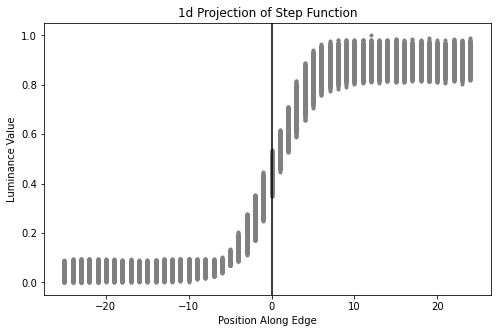

In [15]:
x = np.arange(-halfwidth,halfwidth)
xvals = np.repeat(x,filtered_frame.shape[1])
proj_1d_vals = crop.flatten()

plt.plot(xvals,proj_1d_vals,'.',c='grey',label='data')
plt.axvline(0,label='zero', c='k')
plt.xlabel('Position Along Edge')
plt.ylabel('Luminance Value')
plt.title('1d Projection of Step Function')

## Logistic Function

Logistic Function equation:

$$L(x) = \frac{1}{1+e{-Bx}}$$

$$\frac{dy}{dx} = B L(x) (1-L(x))$$

$$\frac{dy}{dx} = B \frac{1}{1+e{-Bx}} (1-\frac{1}{1+e{-Bx}})$$


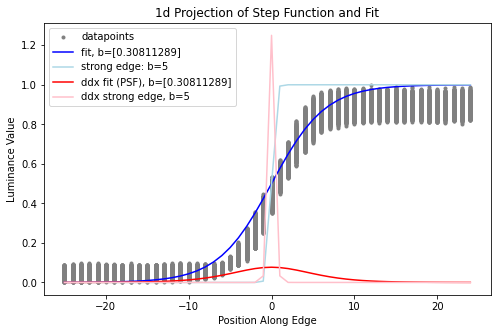

In [24]:
def logistic_func(x, B):
    y = 1/(1+np.exp(-B*x))
    return(y)

def ddt_logistic_func(x,B):
    ddty = B*logistic_func(x,B)*(1-logistic_func(x,B))
    #ddty = (B*np.exp(-B*x))/((1+np.exp(-B*x))**-2)
    return(ddty)

bopt, bcov = scipy.optimize.curve_fit(logistic_func,xvals,proj_1d_vals, p0=1.0)
bstrongedge = 5

plt.plot(xvals,proj_1d_vals,'.',c='grey', label='datapoints')
plt.plot(x, logistic_func(x, B=bopt), c='b', label=f'fit, b={bopt}')
plt.plot(x, logistic_func(x, B=bstrongedge), c='lightblue', label=f'strong edge: b={bstrongedge}')
plt.plot(x, ddt_logistic_func(x, B=bopt), c='r', label=f'ddx fit (PSF), b={bopt}')
plt.plot(x, ddt_logistic_func(x, B=bstrongedge), c='pink', label=f'ddx strong edge, b={bstrongedge}')


plt.xlabel('Position Along Edge')
plt.ylabel('Luminance Value')
plt.title('1d Projection of Step Function and Fit')
plt.legend()

# Convert to 2D PSF

Text(0.5, 1.0, 'Ideal Point Spread Function (Target)')

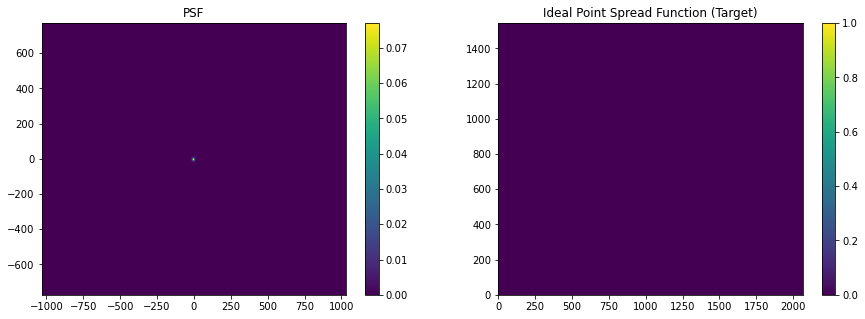

In [17]:
def psf_func_2d(x,y,b=bopt):
    dist = np.hypot(x,y)
    response = ddt_logistic_func(dist,B=b)
    return(response)

x_full= np.arange(-frame.shape[1]//2,frame.shape[1]//2)
y_full = np.arange(-frame.shape[0]//2,frame.shape[0]//2)

psf2d = np.meshgrid(x_full, y_full)
psf2d = psf_func_2d(*psf2d)

psf2d_ideal = np.zeros_like(frame[:,:,0])
psf2d_ideal[frame.shape[0]//2, frame.shape[1]//2] = 1

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.pcolormesh(x_full, y_full, psf2d, shading='auto')
plt.colorbar()
plt.title('PSF')

plt.subplot(1,2,2)
plt.pcolormesh(psf2d_ideal)
plt.colorbar()
plt.title('Ideal Point Spread Function (Target)')

In [18]:
def spatialft(image, cosine_window=True, rmdc=True, power=True):
    """Take the fourier transform of an image (or flow field).
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""

    #remove color dimension
    if(image.ndim >2):
        image = np.mean(image,axis=-1)
    
    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    if(cosine_window):
        cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
        image = image * cosfilter
    
    # remove DC component
    if(rmdc):
        image =  image - np.mean(image)
    
    spec = np.fft.fftshift(np.fft.fft2(image))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(image)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(image)[1]))]

    if power:
        return(np.abs(spec)**2, fqs)
    else:
        return(spec, fqs)

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(<AxesSubplot:title={'center':'MTF Kernel'}>,
 Text(0.5, 1.0, 'MTF Kernel'))

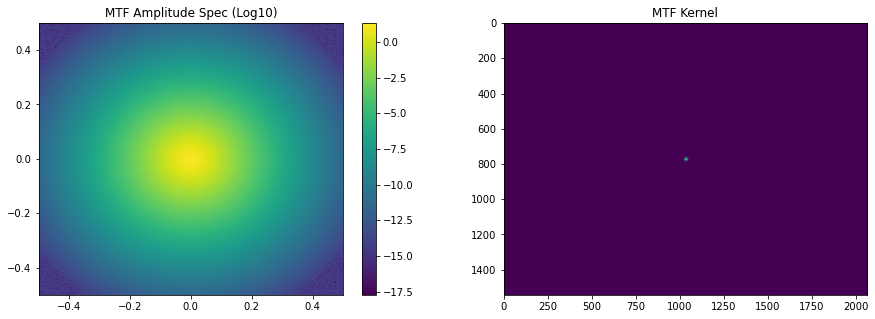

In [31]:
target_spectrum, fqs = spatialft(psf2d_ideal, cosine_window=False, power=False)
measured_spectrum, fqs = spatialft(psf2d, cosine_window=False, power=False)

mtf_spectrum = measured_spectrum / target_spectrum
mtf_kernel_2d = np.real(np.fft.ifft2(np.fft.ifftshift(mtf_spectrum)))

plt.figure(figsize=(15,5))
plt.subplot(121),plt.pcolormesh(fqs[1], fqs[0], np.log10(np.abs(mtf_spectrum))),plt.title('MTF Amplitude Spec (Log10)')
plt.colorbar()
plt.subplot(122),plt.imshow(psf2d),plt.title('MTF Kernel')


Text(0.5, 1.0, 'Azimuthal Averaged Amplitude Spectra')

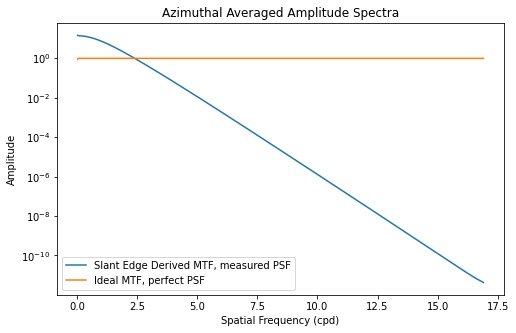

In [20]:
mtf_1d, fqs1d = stf.azimuthalAverage(np.abs(mtf_spectrum), 0.5, bin_in_log=False)
mtf_1d_ideal, fqs1d = stf.azimuthalAverage(np.abs(target_spectrum), 0.5, bin_in_log=False)
img_dims = (1544,2064)
horizontal_fov_deg = 61.
horiz_ppd = img_dims[1]/horizontal_fov_deg
fqs_cpd_1d = fqs1d * horiz_ppd
plt.plot(fqs_cpd_1d, mtf_1d,label='Slant Edge Derived MTF, measured PSF')
plt.plot(fqs_cpd_1d, mtf_1d_ideal,label='Ideal MTF, perfect PSF')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Azimuthal Averaged Amplitude Spectra')

Text(0.5, 1.0, 'Calculated Modulation Transfer Function')

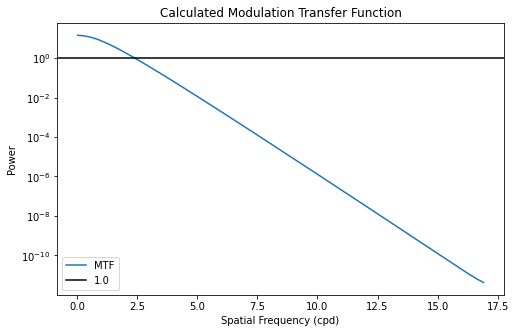

In [26]:
mtf = mtf_1d / mtf_1d_ideal
plt.plot(fqs_cpd_1d, mtf, label='MTF')
plt.axhline(1.0, c='k', label='1.0')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Power')
plt.legend()
plt.title('Calculated Modulation Transfer Function')

## Calculated Incorrectly?
Need to investigate why the result is the same down here, even though the method is totally different.

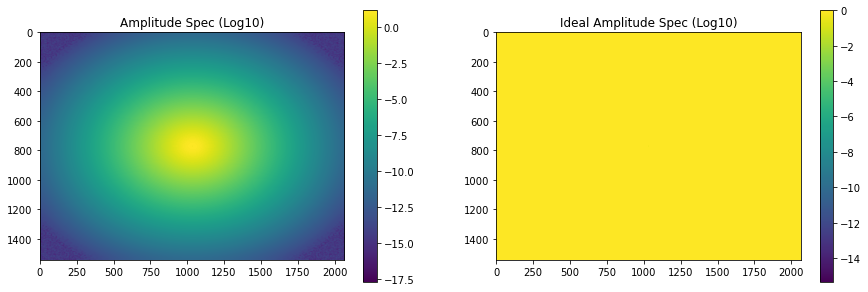

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
psf_ft, fqs = spatialft(psf2d,cosine_window=False, power=False)
plt.imshow(np.log10(np.abs(psf_ft))),plt.title('Amplitude Spec (Log10)')
plt.colorbar()
plt.subplot(1,2,2)
psf_ft_ideal, fqs = spatialft(psf2d_ideal,cosine_window=False, power=False)
plt.imshow(np.log10(np.abs(psf_ft_ideal))),plt.title('Ideal Amplitude Spec (Log10)')
plt.colorbar()

Text(0.5, 1.0, 'Azimuthal Averaged Amplitude Spectra')

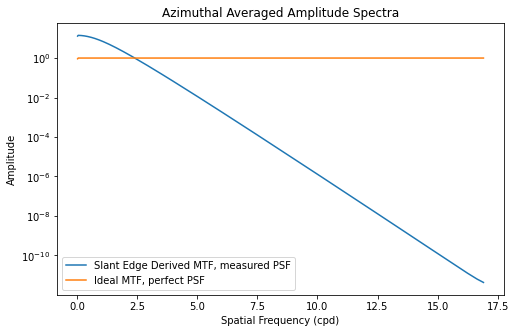

In [23]:
mtf_1d, fqs1d = stf.azimuthalAverage(np.abs(psf_ft), 0.5, bin_in_log=False)
mtf_1d_ideal, fqs1d = stf.azimuthalAverage(np.abs(psf_ft_ideal), 0.5, bin_in_log=False)
img_dims = (1544,2064)
horizontal_fov_deg = 61.
horiz_ppd = img_dims[1]/horizontal_fov_deg
fqs_cpd_1d = fqs1d * horiz_ppd
plt.plot(fqs_cpd_1d, mtf_1d,label='Slant Edge Derived MTF, measured PSF')
plt.plot(fqs_cpd_1d, mtf_1d_ideal,label='Ideal MTF, perfect PSF')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Azimuthal Averaged Amplitude Spectra')